In [1]:
import pickle
import numpy as np

pncdir = '/home/anton/Documents/Tulane/Research/data-sav/anton/cohorts/PNC/'
pncdemo = pickle.load(open(f'{pncdir}/demographics.pkl', 'rb'))

rest = []
nback = []
emoid = []
race = []
sex = []
age = []

for sub in pncdemo['age_at_cnb']:
    try:
        ra = pncdemo['Race'][sub]
        ag = pncdemo['age_at_cnb'][sub]
        se = pncdemo['Sex'][sub]
        if ra not in ['AA', 'EA']:
            continue
        ra = ra == 'AA'
        se = se == 'M'
        r = np.load(f'{pncdir}/fc/{sub}_task-rest_fc.npy')
        n = np.load(f'{pncdir}/fc/{sub}_task-nback_fc.npy')
        e = np.load(f'{pncdir}/fc/{sub}_task-emoid_fc.npy')
        race.append(ra)
        sex.append(se)
        age.append(ag)
        rest.append(r)
        nback.append(n)
        emoid.append(e)
    except:
        pass

rest = np.stack(rest)
nback = np.stack(nback)
emoid = np.stack(emoid)
race = np.array(race).astype('int')
sex = np.array(sex).astype('int')
age = np.array(age)

print([a.shape for a in [rest, nback, emoid, race, sex, age]])

[(1193, 34716), (1193, 34716), (1193, 34716), (1193,), (1193,), (1193,)]


In [179]:
# Nback classifier

from sklearn.linear_model import LogisticRegression

xtr = np.concatenate([rest, nback])
ytr = np.concatenate([np.zeros(len(nback)), np.ones(len(rest))])

clf = LogisticRegression(C=100, max_iter=1000).fit(xtr, ytr)
yhat = clf.predict(xtr)
print(yhat)

xtr = rest
ytr = sex

clf_sex = LogisticRegression(C=100, max_iter=1000).fit(xtr, ytr)
yhat = clf_sex.predict(xtr)
print(yhat == ytr)

[0. 0. 0. ... 1. 1. 1.]
[ True  True  True ...  True  True  True]


In [234]:
def match_sub(ages, sexes, races, a, s, r, atol=2):
    res = []
    for i in range(len(ages)):
        ac = ages[i]
        sc = sexes[i]
        rc = races[i]
        if np.abs(ac-a) > atol:
            continue
        if sc != s:
            continue
        if rc != r:
            continue
        res.append(i)
    return res

def task_diffs(sub_idcs, orig, target, orig_idx):
    diffs = []
    for i in sub_idcs:
        if i == orig_idx:
            continue
        d = 1*(target[i]-orig[i])
        diffs.append(d)
    return diffs

def apply_diffs(diffs, orig, clfs=None, regs=None, clf_tgts=None, regs_lower=None, regs_upper=None):
    nres = 20
    nsamp = 1
    res = []
    ncutoff = 100
    natt = 0
    while len(res) < nres:
        r = []
        for j in np.random.permutation(len(diffs))[:nsamp]:
            r.append(orig+diffs[j])
        r = np.stack(r)
        r = np.mean(r, axis=0)
        if natt < ncutoff and (clfs is not None or regs is not None):
            fail = False
            natt += 1
            for clf,tgt in zip(clfs, clf_tgts):
                yhat = clf.predict(np.expand_dims(r,0))
                if yhat[0] != tgt:
                    fail = True
                    break
            if not fail:
                res.append(r)
        else:
            res.append(r)
    return res, natt >= ncutoff

def rmse(yhat, y):
    return np.mean((yhat-y)**2)**0.5

null_errs = []
task_errs = []
max_errs = []
avg_errs = []
min_errs = []
imputs = []

mod1 = rest
mod2 = nback
task_diff = np.mean(mod2-mod1, axis=0)

for subi in range(10):
    # print(age[subi], sex[subi], race[subi])
    
    matches = match_sub(age, sex, race, age[subi], sex[subi], race[subi])
    # print(len(matches))
    
    diffs = task_diffs(matches, mod1, mod2, subi)
    imput, failed = apply_diffs(diffs, mod1[subi], clfs=[clf, clf_sex], clf_tgts=[1, sex[subi]])
    imputs.append(imput)

    if failed:
        print(f'Failed sub {subi}')
    
    ne = rmse(mod1[subi], mod2[subi])
    te = rmse(task_diff+mod1[subi], mod2[subi])
    errs = [rmse(im, mod2[subi]) for im in imput]
    # print(errs)
    null_errs.append(ne)
    task_errs.append(te)
    max_errs.append(max(errs))
    avg_errs.append(np.mean(errs))
    min_errs.append(min(errs))

print([np.mean(e) for e in [null_errs, task_errs, max_errs, avg_errs, min_errs]])

[0.261048687565574, 0.25604404739438585, 0.5228225120695857, 0.34542452172564353, 0.2739071423763108]


In [172]:
from scipy.spatial import distance

D = np.zeros((len(rest), len(nback)))

for i in range(len(rest)):
    for j in range(i+1,len(nback)):
        D[i,j] = distance.euclidean(rest[i], rest[j])
        D[j,i] = D[i,j]
    if i % 50 == 0:
        print(f'Done {i}')

print(D)

Done 0
Done 50
Done 100
Done 150
Done 200
Done 250
Done 300
Done 350
Done 400
Done 450
Done 500
Done 550
Done 600
Done 650
Done 700
Done 750
Done 800
Done 850
Done 900
Done 950
Done 1000
Done 1050
Done 1100
Done 1150
[[ 0.         48.09949613 43.74573933 ... 56.63201378 47.75694441
  64.54766911]
 [48.09949613  0.         46.76411873 ... 43.74435379 40.28371668
  59.02568656]
 [43.74573933 46.76411873  0.         ... 56.20053917 47.236857
  63.6353573 ]
 ...
 [56.63201378 43.74435379 56.20053917 ...  0.         47.50626262
  63.65712128]
 [47.75694441 40.28371668 47.236857   ... 47.50626262  0.
  59.87875475]
 [64.54766911 59.02568656 63.6353573  ... 63.65712128 59.87875475
   0.        ]]


In [173]:
idcs = np.argsort(D, axis=1)

In [279]:
min_errs = []
yhats = []

for i in range(100):
    sim = idcs[i][1:10]
    errs = []
    for j in sim:
        err = rmse(nback[j], nback[i])
        errs.append(err)
    min_errs.append(min(errs))
    task_pred = clf.predict(np.expand_dims(yhat, 0))[0]
    yhats.append(nback[sim])
    print(task_pred == 1)

print(np.mean(min_errs))

True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
0.21594651315034852


In [183]:
ours2orig = [12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27,
28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 254, 41, 42, 43, 44, 45,
46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64,
65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 85,
86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103,
104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118,
119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 136, 138, 132,
133, 134, 135, 220, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152,
153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167,
168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 185, 186,
187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201,
202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216,
217, 218, 219, 221, 222, 223, 224, 225, 226, 227, 228, 229, 230, 231, 232,
233, 137, 234, 235, 236, 237, 238, 239, 240, 241, 250, 251, 255, 256, 257,
258, 259, 260, 261, 262, 263, 242, 243, 244, 245, 0, 1, 2, 3, 4, 5, 6, 7, 8,
9, 10, 11, 83, 84, 131, 139, 140, 141, 181, 182, 183, 184, 246, 247, 248,
249, 252, 253]

def vec2mat(v):
    a,b = np.triu_indices(264,1)
    m = np.zeros((264,264))
    m[a,b] = v
    return m+m.T

def remap(fc, roimap=ours2orig):
    fc = fc[roimap,:]
    fc = fc[:,roimap]
    return fc

print('Complete')

Complete


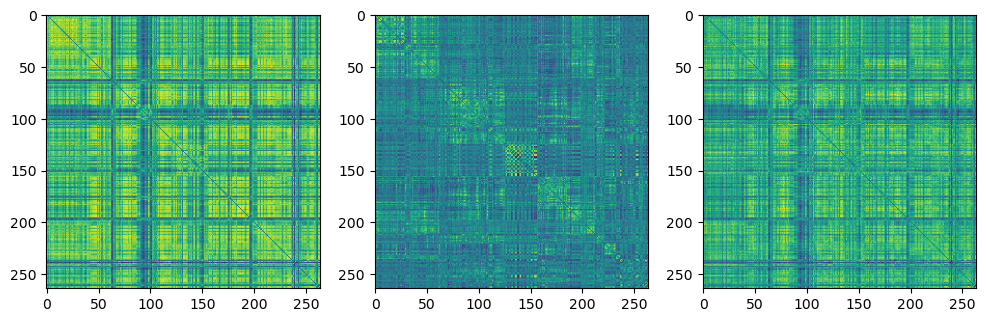

In [284]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1,3,figsize=(12,5))

subi = 6
ii = 8

ax[0].imshow(remap(vec2mat(rest[subi])))
ax[1].imshow(remap(vec2mat(nback[subi])))
ax[2].imshow(remap(vec2mat(imputs[subi][ii])))
# ax[2].imshow(remap(vec2mat(yhats[subi][ii])))

fig.show()